<a href="https://colab.research.google.com/github/Sauleh-repo/CIT/blob/main/ViT(UPAD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mahdavi1202/skin-cancer

import zipfile
import os

with zipfile.ZipFile('skin-cancer.zip', 'r') as zip_ref:
    zip_ref.extractall('skin-cancer')


Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/mahdavi1202/skin-cancer
License(s): Attribution 4.0 International (CC BY 4.0)
skin-cancer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
os.listdir('skin-cancer')
import pandas as pd
import shutil
os.mkdir("/content/all_images")
source_dir="skin-cancer/imgs_part_1/imgs_part_1"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="skin-cancer/imgs_part_2/imgs_part_2"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="skin-cancer/imgs_part_3/imgs_part_3"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

FileExistsError: [Errno 17] File exists: '/content/all_images'

<Axes: xlabel='diagnostic'>

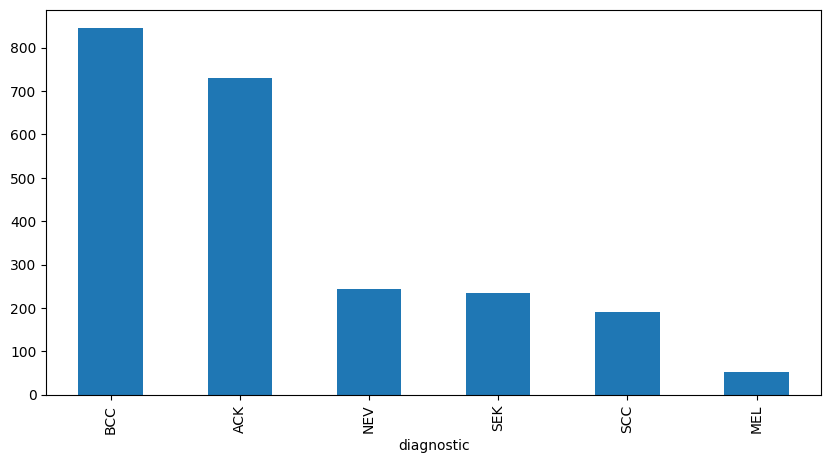

In [7]:
data = pd.read_csv("skin-cancer/metadata.csv")
data['full_link'] = 'all_images/' + data['img_id']
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
data['diagnostic'].value_counts().plot(kind='bar', ax=ax1)



In [8]:
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# a function for encoding classes
def create_class(X):
    if X == 'BCC':
        return 0
    elif X =='ACK':
        return 1
    elif X == 'NEV':
        return 2
    elif X == 'SEK':
        return 3
    elif X == 'SCC':
        return 4
    elif X == 'MEL':
        return 5
    else:
        print('error class')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [10]:

data['encoded_class'] = data['diagnostic'].apply(create_class)
data.drop(['diagnostic'], axis = 1, inplace = True)
data.sort_values(by ='patient_id', ascending = True, inplace = True, ignore_index = True)
data.info()
data.drop([ 'biopsed','patient_id','img_id','lesion_id','smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history',
         'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'], axis = 1, inplace = True)
data.info()

from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np


IMG_SIZE = 32,32
BATCH_SIZE = 256
SEED = 55

AUTO = tf.data.AUTOTUNE
train_data = data[:2000]
test_data = data[2000:]
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

print('train  ->', train_data.shape)
print('test  ->', test_data.shape)
counts = np.bincount(train_data['encoded_class'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]
weight_for_3 = 1.0 / counts[3]
weight_for_4 = 1.0 / counts[4]
weight_for_5 = 1.0 / counts[5]

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}
class_weight
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class ClassToken(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.cls = self.add_weight(             #adding a trainable paramter to a custom layer
            name="cls",                         #name of the weight
            shape=(1, 1, input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]
        cls = tf.tile(self.cls, [batch_size, 1, 1])
        x = tf.concat([cls, x], axis=1)
        return x

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):

    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)

    patch_embed = Dense(cf["hidden_dim"])(inputs)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    embed = patch_embed + pos_embed


    x = ClassToken()(embed)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = LayerNormalization()(x)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [11]:
import tensorflow as tf

def create_positional_embedding(num_patches, embedding_dim):
    return tf.random.normal(shape=(1,num_patches,embedding_dim))

def preprocess_image(image, patch_size, target_size=(224, 224)):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, target_size)

    image = tf.cast(image, tf.float32) / 255.0

    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, axis=0),
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    num_patches = (target_size[0] // patch_size) * (target_size[1] // patch_size)
    patch_dim = patch_size * patch_size * 3
    patches = tf.reshape(patches, (num_patches, patch_dim))

    return patches
image = tf.random.normal(shape=(28,28,3))

patch_size = 16
processed_patches = preprocess_image(image, patch_size)
print("Shape of processed patches:", processed_patches.shape)

patch_size = 32
processed_patches = preprocess_image(image, patch_size)
print("Shape of processed patches:", processed_patches.shape)
image = tf.random.normal(shape=(100,150,3))

patch_size = 16
processed_patches = preprocess_image(image, patch_size)
print("Shape of processed patches:", processed_patches.shape)

patch_size = 32
processed_patches = preprocess_image(image, patch_size)
print("Shape of processed patches:", processed_patches.shape)

Shape of processed patches: (196, 768)
Shape of processed patches: (49, 3072)
Shape of processed patches: (196, 768)
Shape of processed patches: (49, 3072)


In [12]:
def preprocess_data(data):
  images, labels = [], []
  for index, row in data.iterrows():
    image_path = row['full_link']
    image = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    image = tf.keras.utils.img_to_array(image)

    processed_image = preprocess_image(image, patch_size=cf["patch_size"])
    images.append(processed_image)
    labels.append(row['encoded_class'])

  return np.array(images), np.array(labels)

In [15]:

train_images, train_labels = preprocess_data(train_data)

test_images, test_labels = preprocess_data(test_data)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 55
cf = {
    "patch_size": 16,
    "num_patches": (IMG_SIZE[0] // 16) * (IMG_SIZE[1] // 16),
    "num_channels": 3,
    "hidden_dim": 768,
    "mlp_dim": 3072,
    "num_heads": 12,
    "num_layers": 12,
    "dropout_rate": 0.1,
    "num_classes": 6,
    "weight_decay": 1e-6,
    "learning_rate": 1e-3
}

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

model = ViT(cf)

optimizer = Adam(learning_rate=cf["learning_rate"], weight_decay=cf["weight_decay"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight
)

# Evaluation
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


#Previously working


In [ ]:
def load_and_preprocess_image(image_path, label):
    """Loads an image, preprocesses it, and returns (image, label)."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure the image is 3D
    img = tf.image.resize(img, IMG_SIZE)  # Resize to target size (e.g., 32x32)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values
    return img, label

def augment(image, label):
    """Applies data augmentation."""
    # Apply augmentation on the 3D image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label


In [ ]:
def preprocess_image(image, patch_size):
    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, axis=0),  # Add batch dimension
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patches = tf.reshape(patches, [-1, patch_size * patch_size * 3])  # Flatten patches
    return patches

train_image_paths = train_data['full_link'].values
train_labels = train_data['encoded_class'].values

test_image_paths = test_data['full_link'].values
test_labels = test_data['encoded_class'].values

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
    .map(load_and_preprocess_image, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)  # Apply augmentation
    .map(lambda img, lbl: (preprocess_image(img, cf["patch_size"]), lbl), num_parallel_calls=AUTO)  # Extract patches
    .shuffle(buffer_size=len(train_image_paths))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
    .map(load_and_preprocess_image, num_parallel_calls=AUTO)
    .map(lambda img, lbl: (preprocess_image(img, cf["patch_size"]), lbl), num_parallel_calls=AUTO)  # Extract patches
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Model Compilation
cf = {
    "num_patches": (IMG_SIZE[0] // cf["patch_size"]) * (IMG_SIZE[1] // cf["patch_size"]),
    "patch_size": 4,
    "num_channels": 3,
    "hidden_dim": 64,
    "mlp_dim": 128,
    "num_heads": 4,
    "num_layers": 4,
    "dropout_rate": 0.1,
    "num_classes": 6,
}

model = ViT(cf)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

#Training
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    class_weight=class_weight
)

#Evaluating
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

model.save('skin_cancer_vit_model.h5')

# Example Prediction Function
def predict_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    patches = tf.image.extract_patches(
        images=tf.expand_dims(img, axis=0),  # Add batch dimension for prediction
        sizes=[1, cf["patch_size"], cf["patch_size"], 1],
        strides=[1, cf["patch_size"], cf["patch_size"], 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patches = tf.reshape(patches, [-1, cf["patch_size"] * cf["patch_size"] * 3])
    patches = tf.expand_dims(patches, axis=0)  # Add batch dimension for ViT input

    prediction = model.predict(patches)
    predicted_class = np.argmax(prediction)
    return predicted_class




In [ ]:
# Example usage:
sample_image_path = test_image_paths[15]
predicted_class = predict_image(sample_image_path)
print(f"Predicted class for {sample_image_path}: {predicted_class}")

#Classification Report

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 55
cf = {
    "patch_size": 16,  #Experiment with 16 or 32
    "num_patches": (IMG_SIZE[0] // 16) * (IMG_SIZE[1] // 16),
    "num_channels": 3,
    "hidden_dim": 768,
    "mlp_dim": 3072,
    "num_heads": 12,
    "num_layers": 12,
    "dropout_rate": 0.1,
    "num_classes": 6,
    "weight_decay": 1e-6,
    "learning_rate": 1e-3
}

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

model = ViT(cf)
model.summary()

optimizer = Adam(learning_rate=cf["learning_rate"], weight_decay=cf["weight_decay"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight
)


# Evaluation
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report and Confusion Matrix
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Plotting training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

remove all the plots and redundancy. only focus on training the model and calculating the accuracy of our model